In [1]:
import numpy as np 
from astropy.io import ascii
#import scipy.special
import matplotlib.pyplot as plt
#from sklearn.model_selection import cross_val_score, GridSearchCV,cross_val_predict,train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import KFold
#from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.optimize import curve_fit
import scipy.stats as stats



In [2]:
names =['scale','ID','desc_scale','desc_id','num_prog','pid','upid','desc_pid',
    'phantom','sam_mvir','Mvir','Rvir','Rs', 'vrms', 'mmp', 'scale_of_last_MM',
    'Vmax', 'X','Y','Z','VX','VY','VZ','JX','JY','JZ','Spin','Breadth_first_ID',
    'Depth_first_ID','Tree_root_ID','Orig_halo_ID','Snap_num',
    'Next_coprogenitor_depthfirst_ID','Last_progenitor_depthfirst_ID',
    'Rs_Klypin','Mvir_all','M200b','M200c','M500c','M2500c','Xoff','Voff',
    'spin_bullock','b_to_a','c_to_a','A[x]','A[y]','A[z]','b_to_a(500c)',
    'c_to_a(500c)','A[x](500c)','A[y](500c)','A[z](500c)','T/|U|','Macc',
    'Mpeak','Vacc','Vpeak','Halfmass_Scale','Acc_Rate_Inst','Acc_Rate_100Myr',
    'Acc_Rate_Tdyn']

In [3]:
host_vals = ascii.read('host_og_vals.table', format = 'commented_header') 

rvirs = host_vals['rvir']
mvirs = host_vals['mvir']
hostx = host_vals['hostx']
hosty = host_vals['hosty']
hostz = host_vals['hostz']
hostvx = host_vals['hostvx']
hostvy =host_vals['hostvy']
hostvz = host_vals['hostvz']
host_shapes = host_vals['host_shapes']
host_spins = host_vals['host_spins']
host_cs = host_vals['host_cs']
hostJx = host_vals['hostJx']
hostJy = host_vals['hostJy']
hostJz = host_vals['hostJz']

halo_names = []
host_ids = []
rvirs = []
mvirs = []
vmaxs = []

with open('halos_info.txt') as f:
    for l in f:
        this_halo, host_id, block, _ = l.split()
        halo_names.append(this_halo)
        host_ids.append(host_id)
        hostvalues = ascii.read('/Users/lmezini/proj_2/Halos_Recalculated/{}/out_0.list_final'.format(this_halo),format = 'commented_header')
        rvirs.append(hostvalues['host_rvir'][0])
        mvirs.append(hostvalues['host_mvir'][0])
        vmaxs.append(hostvalues['vmax'][0])

hlist_host_ids = []
with open('hlist_halo_ids.txt') as f:
    for l in f:
        this_halo, host_id = l.split()
        hlist_host_ids.append(int(host_id))



In [4]:
sub_pos = []
sub_mass = []
sub_rvir = []
host_pos = []
host_TU_val = []
host_acc_rate_tdyn = []
host_acc_rate_100myr = []
host_c = []
for i,halo in enumerate(halo_names):
    hostvalues = ascii.read('/Users/lmezini/proj_2/rs_files/{}/hlist.list'.format(halo),names=names)
    loc = int(np.where(hostvalues['ID']==int(hlist_host_ids[i]))[0][0])

    halo_rvir = hostvalues['Rvir'][loc]
    halo_mvir = hostvalues['Mvir'][loc]
    
    host_TU_val.append(hostvalues['T/|U|'][loc])
    host_acc_rate_tdyn.append(hostvalues['Acc_Rate_Tdyn'][loc])
    host_acc_rate_100myr.append(hostvalues['Acc_Rate_100Myr'][loc])
    host_c.append(hostvalues['Rvir'][loc]/hostvalues['Rs'][loc])

    ##Position in Mpc/h##
    halox = hostvalues['X'][loc]
    haloy = hostvalues['Y'][loc]
    haloz = hostvalues['Z'][loc]
    host_pos.append(np.array((halox, haloy, haloz)))

    hostvalues.remove_row(loc)
    wh = np.where(hostvalues['upid']==int(hlist_host_ids[i]))
    hostvalues = hostvalues[wh]
    
    ##Position in Mpc/h##
    subx = hostvalues['X']
    suby = hostvalues['Y']
    subz = hostvalues['Z']

    r = np.sqrt((subx - halox)**2+(suby - haloy)**2+(subz - haloz)**2)
    #mean_r[i] += np.mean(r)

    wh = np.where(r<halo_rvir)
    hostvalues = hostvalues[wh]

    wh = hostvalues['Vmax']>10.
    hostvalues = hostvalues[wh]

    subx = hostvalues['X']
    suby = hostvalues['Y']
    subz = hostvalues['Z']

    r = np.sqrt((subx - halox)**2+(suby - haloy)**2+(subz - haloz)**2)

    posx = (subx - halox)
    posy = (suby - haloy) 
    posz = (subz - haloz) 
    pos = np.array(list(zip(posx, posy, posz)))
    sub_mass.append(hostvalues['Mvir'])
    sub_pos.append(pos)
    sub_rvir.append(hostvalues['Rvir'])



In [5]:
jsubs_jhost_angs = np.array([0.96120916, 0.83244424, 0.83373664, 0.50750575, 0.92927496,
       0.95872028, 0.30154109, 0.8594474 , 0.23314348, 0.2493161 ,
       0.69984051, 0.91083318, 0.91174542, 0.78552653, 0.94364538,
       0.57178404, 0.71523852, 0.73722746, 0.8360834 , 0.98803   ,
       0.99788098, 0.93729526, 0.42859609, 0.91937514, 0.60439602,
       0.22565998, 0.92713759, 0.35072081, 0.99531559, 0.97213375,
       0.95255881, 0.95675472, 0.62498674, 0.78518782, 0.99892756,
       0.55884304, 0.97002538, 0.29746222, 0.6735368 , 0.96597007,
       0.97807438, 0.6269004 , 0.58810487, 0.0219024 , 0.960565  ])

In [67]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
            'max_depth': range(1,2),
            'n_estimators': (10, 50, 100, 1000),
        },
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')
    predictions = cross_val_predict(rfr, X, y, cv=10)
    return scores, predictions, best_params

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
y_train = y_train
y_test = y_test

RandomForestRegressor(max_depth=1, n_estimators=50, random_state=0)

Mean Absolute Error: -0.019, Standard Deviation : 0.009
Mean Absolute Error: -1.010, Standard Deviation : 2.018


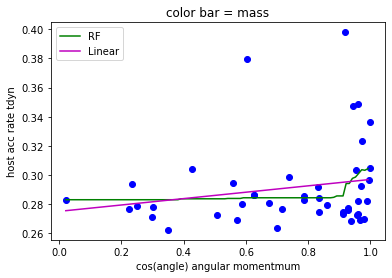

In [122]:
X,y = jsubs_jhost_angs.reshape(-1, 1), np.array(host_TU_val)

rfr = RandomForestRegressor(n_estimators = 50, random_state = 0,max_depth=1)
rfr.fit(X, y)

folds = 5
kfold = KFold(n_splits=folds)
# set scoring parameter to 'neg_mean_absolute_error'
scoring = 'neg_mean_absolute_error'

# call cross_val_score() to run cross validation
resultArr = cross_val_score(rfr, X, y, cv=kfold, scoring=scoring)

# calculate mean of scores for all folds
mae = resultArr.mean()

# calculate standard deviation
stdAccuracy = resultArr.std()

# display Mean Absolute Error
# descending score(smallest score is best) is denoted by negative even though the value is positive
print("Mean Absolute Error: %.3f, Standard Deviation : %.3f" % (mae, stdAccuracy))


model = LinearRegression()
model.fit(X,y)
# set scoring parameter to 'neg_mean_absolute_error'
scoring = 'neg_mean_absolute_error'

# call cross_val_score() to run cross validation
resultArr = cross_val_score(model, X, y, cv=kfold)#, scoring=scoring)

# calculate mean of scores for all folds
mae = resultArr.mean()

# calculate standard deviation
stdAccuracy = resultArr.std()

# display Mean Absolute Error
# descending score(smallest score is best) is denoted by negative even though the value is positive
print("Mean Absolute Error: %.3f, Standard Deviation : %.3f" % (mae, stdAccuracy))

X_grid = np.arange(min(X), max(X),0.01)# (max(jsubs_jhost_angs)-min(jsubs_jhost_angs))/45)

# reshape for reshaping the data into a len(X_grid)*1 array,
# i.e. to make a column out of the X_grid value                 
X_grid = X_grid.reshape(len(X_grid), 1)

# Scatter plot for original data
t = (mvirs)
plt.scatter(X, y, color='blue')
#plt.colorbar()
# plot predicted data
plt.plot(X_grid, rfr.predict(X_grid),
         color = 'green',label='RF')
plt.plot(X_grid,model.predict(X_grid),color='m',label='Linear')
plt.title('color bar = mass')
plt.ylabel('host acc rate tdyn')
plt.xlabel('cos(angle) angular momentmum')
plt.legend()
plt.show()


In [72]:
X,y = jsubs_jhost_angs.reshape(-1, 1), np.array(host_acc_rate_tdyn)
scores,predictions,best_params = rfr_model(X, y)

In [83]:
print(scores.mean(),predictions,best_params)

-32.723212621271685 [56.39996741 32.86301233 32.86301233 27.47738085 47.46167482 56.9111133
 24.85333215 32.12917921 24.85333215 24.85333215 35.91767758 42.76410669
 42.76410669 35.91767758 43.62681301 27.57202536 34.52225206 34.52225206
 34.52225206 57.54098545 46.62115307 47.18781556 23.07670779 23.99146826
 22.98098873 23.14476989 49.75507533 23.14476989 60.13228667 43.94963953
 43.82522011 43.82522011 29.84561589 28.87762142 74.67922623 24.30527885
 59.85335884 24.78319555 29.61440912 60.2822792  61.75340611 31.14809048
 31.14809048 26.53476713 48.76009044] {'max_depth': 1, 'n_estimators': 100}


/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_40923/814932768.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(param1.reshape(-1, 1),(param2).reshape(-1, 1))


0.09396066331298192


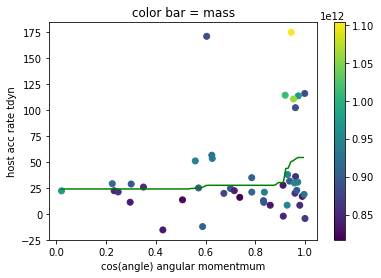

In [107]:
param1 = jsubs_jhost_angs
param2 = np.array(host_acc_rate_tdyn)
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0,max_depth=1)
regressor.fit(param1.reshape(-1, 1),(param2).reshape(-1, 1)) 
print(regressor.score(param1.reshape(-1, 1),(param2).reshape(-1, 1), sample_weight=None))
# Visualising the Random Forest Regression results
 
# arrange for creating a range of values
# from min value of x to max
# value of x with a difference of 0.01
# between two consecutive values
X_grid = np.arange(min(param1), max(param1),0.01)# (max(jsubs_jhost_angs)-min(jsubs_jhost_angs))/45)

# reshape for reshaping the data into a len(X_grid)*1 array,
# i.e. to make a column out of the X_grid value                 
X_grid = X_grid.reshape(len(X_grid), 1)

# Scatter plot for original data
t = (mvirs)
plt.scatter(param1, param2, c = t) 
plt.colorbar()
# plot predicted data
plt.plot(X_grid, regressor.predict(X_grid),
         color = 'green')
plt.title('color bar = mass')
plt.ylabel('host acc rate tdyn')
plt.xlabel('cos(angle) angular momentmum')
plt.show()


In [112]:
X,y = jsubs_jhost_angs.reshape(-1, 1), np.array(host_acc_rate_tdyn)
# set k-fold count
folds = 5

# set seed to reproduce the same random data each time
seed = 7

# split data using KFold
kfold = KFold(n_splits=folds)#, random_state=seed)

# instantiate a regression model
model = LinearRegression()

# set scoring parameter to 'neg_mean_absolute_error'
scoring = 'neg_mean_absolute_error'

# call cross_val_score() to run cross validation
resultArr = cross_val_score(model, X, y, cv=kfold)#, scoring=scoring)

# calculate mean of scores for all folds
mae = resultArr.mean()

# calculate standard deviation
stdAccuracy = resultArr.std()

# display Mean Absolute Error
# descending score(smallest score is best) is denoted by negative even though the value is positive
print("Mean Absolute Error: %.3f, Standard Deviation : %.3f" % (mae, stdAccuracy))

Mean Absolute Error: -0.987, Standard Deviation : 1.929


In [110]:
X,y = jsubs_jhost_angs.reshape(-1, 1), np.array(host_acc_rate_tdyn)

# set k-fold count
folds = 5

# set seed to reproduce the same random data each time
seed = 7

# split data using KFold
kfold = KFold(n_splits=folds)#, random_state=seed)

# instantiate a regression model
model = RandomForestRegressor(n_estimators = 50, random_state = seed,max_depth=1)

# set scoring parameter to 'neg_mean_absolute_error'
scoring = 'neg_mean_absolute_error'

# call cross_val_score() to run cross validation
resultArr = cross_val_score(model, X, y, cv=kfold)#, scoring=scoring)

# calculate mean of scores for all folds
mae = resultArr.mean()

# calculate standard deviation
stdAccuracy = resultArr.std()

# display Mean Absolute Error
# descending score(smallest score is best) is denoted by negative even though the value is positive
print("Mean Absolute Error: %.3f, Standard Deviation : %.3f" % (mae, stdAccuracy))

Mean Absolute Error: -0.801, Standard Deviation : 1.335


In [99]:
# Mean absolute error (MAE)
mae = mean_absolute_error(y, predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y, predictions)

# R-squared scores
r2 = r2_score(y, predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 32.76
Mean Squared Error: 2079.7
R-squared scores: -0.13


In [6]:
def step(x,a,b,c): 
    #return a * np.sign(x-b) + c
    return a+np.heaviside(x-b,1)*c

def line(x,a,b):
    return a*x + b

def exp(x,a,b,c):
    return a*(x**b)+c
    #return a*np.exp(x*b)

def chi2(o,e):
    return np.sum(((o-e)**2)/e)

def AIC(chi2,k):
    return chi2+2*k

def BIC(chi2,k,n):
    return chi2 + k*np.log(n)

In [75]:
X,y = jsubs_jhost_angs, np.array(host_TU_val)
popt_step,pcov=curve_fit(step,X,y,bounds=([0.2,0.85,.005],[.35,.97,10]))
#print('popt = %s' % popt_step)
#print('pcov = \n %s' % pcov)

popt_exp,pcov=curve_fit(exp,X,y,bounds=([0.0,10.,0.],[10.0,40,.3]))
#print('popt = %s' % popt_exp)
#print('pcov = \n %s' % pcov)

popt,pcov=curve_fit(line,X,y,bounds=([0,0],[10,50]))
#print('popt = %s' % popt)
#print('pcov = \n %s' % pcov)

Text(0.5, 1.0, 'MWM')

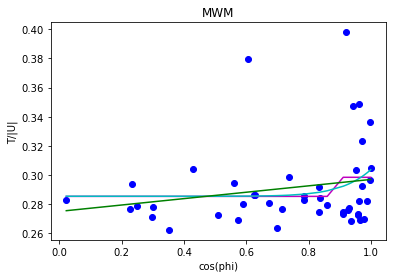

In [77]:
t = (mvirs)
plt.scatter(X, y, c ='b',) 

plt.plot(np.sort(X),step(np.sort(X),popt_step[0],popt_step[1],popt_step[2]),color='m')
plt.plot(np.sort(X),exp(np.sort(X),popt_exp[0],popt_exp[1],popt_exp[2]),color='c')
plt.plot(np.sort(X),line(np.sort(X),popt[0],popt[1]),color='green')
plt.xlabel('cos(phi)')
plt.ylabel('T/|U|')
plt.title('MWM')

In [79]:
step_chi2 = chi2(y,step(X,popt_step[0],popt_step[1],popt_step[2]))
line_chi2 = chi2(y,line(X,popt[0],popt[1]))
exp_chi2 = chi2(y,exp(X,popt_exp[0],popt_exp[1],popt_exp[2]))
print('step chi2,BIC,AIC: {}'.format(step_chi2),BIC(step_chi2,3,42),AIC(step_chi2,3))
print('line chi2,BIC,AIC: {}'.format(line_chi2),BIC(line_chi2,2,43),AIC(line_chi2,2))
print('exp chi2,BIC,AIC: {}'.format(exp_chi2),BIC(exp_chi2,3,42),AIC(exp_chi2,3))

step chi2,BIC,AIC: 0.12013109186220576 11.333139946712311 6.120131091862206
line chi2,BIC,AIC: 0.1219040615400485 7.644304292927173 4.121904061540048
exp chi2,BIC,AIC: 0.12166810643923673 11.334676961289343 6.121668106439237


In [813]:
cut = X>=0.91
X_cut = X[cut]
y_cut = y[cut]
cut = X<0.91
X_cut2 = X[cut]
y_cut2 = y[cut]

In [817]:
print(stats.ks_2samp(line(param1,popt[0],popt[1]),step(param1,popt_step[0],popt_step[1],popt_step[2])))#exp(np.sort(X),popt_exp[0],popt_exp[1],popt_exp[2])))

KstestResult(statistic=0.4444444444444444, pvalue=0.0002237060786301627)


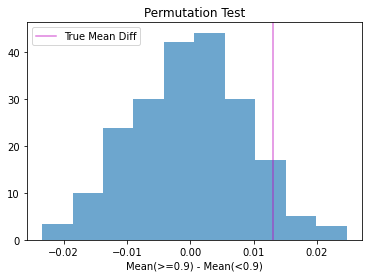

In [89]:
cut_ys = np.zeros(500)
X,y = jsubs_jhost_angs, np.array(host_TU_val)

cut_hi = X>=0.90
x_cut_hi = X[cut_hi]
y_cut_hi = y[cut_hi]

cut_lo = X<0.90
x_cut_lo = X[cut_lo]
y_cut_lo = y[cut_lo]

y_cut_lo_med = np.mean(y_cut_lo)
y_cut_hi_med = np.mean(y_cut_hi)


for i in range(500):
    np.random.shuffle(y)
    y_cut_lo = np.mean(y[cut_lo])
    y_cut_hi = np.mean(y[cut_hi])
    cut_ys[i]+=(y_cut_hi-y_cut_lo)
    #plt.scatter(x_cut,y_cut)
    #plt.show()
plt.hist(cut_ys,density=True,alpha=0.65)
plt.axvline(y_cut_hi_med-y_cut_lo_med,color='m',label='True Mean Diff',alpha=0.5)
plt.legend()
plt.title('Permutation Test')
plt.xlabel('Mean(>=0.9) - Mean(<0.9)')
plt.show()

In [46]:
print(y_cut_med)

0.28205


In [52]:
X,y = jsubs_jhost_angs, np.array(host_TU_val)
y_cut = y[cut]
print(np.mean(y),np.mean(y_cut))

0.2911444444444445 0.29842500000000005
